# PreTrain

In [1]:
from model.sswae_dev2_2 import SSWAE_HSIC_MNIST as cur_model

import os, sys, configparser, logging, argparse, time
sys.path.append('/'.join(os.getcwd().split('/')[:-2]))

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim

from XAE.dataset import rmMNIST
from XAE.dataset import MNIST
from XAE.util import init_params

import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
y_dim = 8
rm = [1]

d = 64
embed_data = nn.Sequential(
    nn.Conv2d(1, d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, 2*d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Conv2d(2*d, 2*d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Flatten(),
).to(device)

embed_condition = nn.Sequential(
    nn.Linear(49*2*d, d),
    nn.BatchNorm1d(d),
    nn.ReLU(True),
    
    nn.Linear(d, y_dim),
).to(device)

enc_activation = nn.Sequential(
    nn.BatchNorm1d(y_dim),
    nn.ReLU(True),
    nn.Linear(y_dim, 10 - len(rm)),
).to(device)

init_params(embed_data)
init_params(embed_condition)
init_params(enc_activation)

In [7]:
labeled_class = [i for i in range(10) if i not in rm]
print("lab:", labeled_class, "rm:", rm)
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, rm], portion = 1.0, unk=False)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

lab: [0, 2, 3, 4, 5, 6, 7, 8, 9] rm: [1]


In [8]:
def kk(x, y, diag = True):
    stat = 0.
    for scale in [.1, .2, .5, 1., 2., 5., 10.]:
        C = scale*2*y_dim*2
        kernel = (C/(C + (x.unsqueeze(0) - y.unsqueeze(1)).pow(2).sum(dim = 2)))
        if diag:
            stat += kernel.sum()
        else:
            stat += kernel.sum() - kernel.diag().sum()
    return stat

In [9]:
epoch = 20
opt = optim.Adam(list(embed_data.parameters()) + list(embed_condition.parameters()) + list(enc_activation.parameters()), lr = 1e-3, betas = (0.9, 0.999))
crit = nn.CrossEntropyLoss()
running_loss = 0.0

for k in range(epoch):
    for i, (data, condition) in enumerate(train_generator):
        opt.zero_grad()
        n = len(data)
        x = data.to(device)
        y = condition.to(device)
        
        xx = embed_condition(embed_data(x))
        output = enc_activation(xx)
        loss = crit(output, y)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        
    print('[%d] loss: %.3f' % (k + 1, running_loss / len(train_generator)))
    running_loss = 0.0

[1] loss: 1.307
[2] loss: 0.175
[3] loss: 0.049
[4] loss: 0.026
[5] loss: 0.018
[6] loss: 0.012
[7] loss: 0.010
[8] loss: 0.008
[9] loss: 0.007
[10] loss: 0.006
[11] loss: 0.004
[12] loss: 0.007
[13] loss: 0.004
[14] loss: 0.005
[15] loss: 0.004
[16] loss: 0.003
[17] loss: 0.001
[18] loss: 0.004
[19] loss: 0.004
[20] loss: 0.004


In [10]:
batch_size = 100
test_data = MNIST('./data/MNIST', train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

a, b = next(iter(test_generator))
embed_condition(embed_data(a.to(device))).shape

torch.Size([100, 8])

In [11]:
f1 = np.zeros((0, 10))
f2 = np.zeros((0, y_dim))

i = 0
for a, b in test_generator:
    f1x = b.to('cpu').detach().numpy()
    f2x = embed_condition(embed_data(a.to(device))).to('cpu').detach().numpy()
    f1 = np.concatenate((f1, f1x), axis = 0)
    f2 = np.concatenate((f2, f2x), axis = 0)
    i += 1
    if i == 5:
        break
        
digit = np.arange(10)
lab = [digit[l.astype(np.bool_)] for l in f1]
lab = np.concatenate(lab)

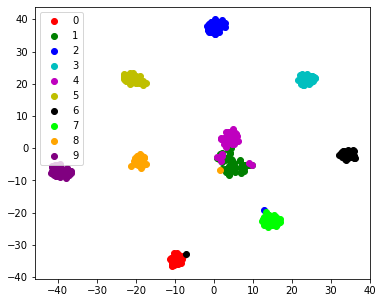

In [12]:
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(f2)

target_ids = list(range(10))

plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(X_2d[lab == i, 0], X_2d[lab == i, 1], c=c, label=str(i))
plt.legend()
plt.show()

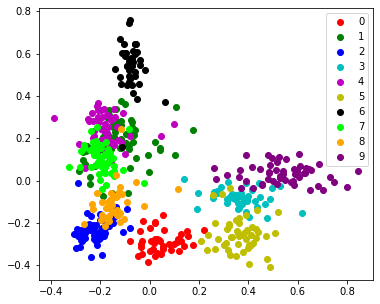

In [13]:
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(f2[lab == i, 0], f2[lab == i, 2], c=c, label=str(i))
plt.legend()
plt.show()

In [14]:
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, rm], portion = 1.0, class_no = True, unk=False)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [15]:
ys = np.zeros((10 - len(rm), y_dim))
cs = np.zeros(10 - len(rm))
covs = np.zeros((10 - len(rm), y_dim, y_dim))

for data, condition in train_generator:
    n = len(data)
    x = data.to(device)
    y = condition.to(device)
    z = embed_condition(embed_data(x))
    labs, idxs, counts = y.unique(dim = 0, return_inverse = True, return_counts = True)
    idxs = labs[idxs].view(n,1).expand(-1, y_dim)
    cc = torch.zeros((10 - len(rm), y_dim), dtype = torch.float).to(device).scatter_add_(0, idxs, z)
    ys += cc.detach().to('cpu').numpy()
    cs += counts[labs].detach().to('cpu').numpy()
    
    for i in range(10 - len(rm)):
        cov = torch.cov(z[y==i,:].T, correction=0) * torch.sum(y==i)
        covs[i,:,:] += cov.detach().to('cpu').numpy()

In [16]:
w1 = torch.Tensor(ys.transpose()/cs)
w1

tensor([[ 0.0218, -0.2237,  0.3666, -0.2213,  0.3185, -0.0756, -0.2168, -0.1448,
          0.5183],
        [ 0.5888,  0.5390,  0.1812, -0.1758, -0.1010,  0.2671, -0.1514, -0.1604,
         -0.1907],
        [-0.2601, -0.2121, -0.0653,  0.2578, -0.2304,  0.5639,  0.1157, -0.1040,
          0.0593],
        [-0.2126,  0.1893, -0.0712, -0.2256,  0.2217,  0.0373, -0.1509,  0.5236,
         -0.0656],
        [-0.1922,  0.1362,  0.4986, -0.1498, -0.2277, -0.2078,  0.4598, -0.1638,
         -0.2540],
        [ 0.5017, -0.2010, -0.2325, -0.1690, -0.1740, -0.1947,  0.3044,  0.3385,
          0.1681],
        [-0.1521,  0.4359, -0.1559,  0.4162, -0.1503, -0.1593,  0.2133, -0.0835,
          0.3413],
        [ 0.0488,  0.1182, -0.0114,  0.5283,  0.6153, -0.1146, -0.0666, -0.1222,
         -0.2173]])

In [17]:
f1 = nn.Linear(10 - len(rm), y_dim, bias = False)
f1.weight.data = w1
torch.save(f1.state_dict(), f'./result/mu_{y_dim}_rm_{str(rm).replace(" ","")[1:-1]}.pt')

In [18]:
w2 = torch.tensor((covs.T / (cs - 1)).T)
w2.shape

torch.Size([9, 8, 8])

In [19]:
for i in range(10 - len(rm)):
    e, v = torch.symeig(w2[i,:,:], eigenvectors = True)
    w2[i,:,:] = v @ torch.diag(torch.sqrt(e)) @ v.T

In [20]:
f2 = nn.ConvTranspose2d(10 - len(rm), 1, y_dim, bias=False)
f2.weight.data = w2.view(10 - len(rm), 1, y_dim, y_dim)
torch.save(f2.state_dict(), f'./result/cov_{y_dim}_rm_{str(rm).replace(" ","")[1:-1]}.pt')

# Train

In [3]:
from XAE.logging_daily import logging_daily

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

logger = logging_daily('./config/log_info.yaml')
log = logger.get_logging()
log.setLevel(logging.INFO)

cfg = configparser.ConfigParser()
cfg.read('./config/sswae_dev2_rm_1.cfg')

['./config/sswae_dev2_rm_1.cfg']

In [4]:
mm = cur_model(cfg, log, device = device)

mm.gm.mu.load_state_dict(torch.load(f'./result/mu_{mm.y_dim}_rm_{str(rm).replace(" ","")[1:-1]}.pt'))
mm.gm.cov.load_state_dict(torch.load(f'./result/cov_{mm.y_dim}_rm_{str(rm).replace(" ","")[1:-1]}.pt'))

mm.train()
# mm.load('./%s' % (cfg['path_info']['save_path']))

[default |INFO|_base_model.py:27] ------------------------------------------------------------
[default |INFO|_base_model.py:29] model_name : SSWAE_HSIC_MNIST
[default |INFO|_base_model.py:29] train_data : rmMNIST
[default |INFO|_base_model.py:29] train_data_label : True
[default |INFO|_base_model.py:29] z_sampler : gaus
[default |INFO|_base_model.py:29] z_dim : 4
[default |INFO|_base_model.py:29] y_sampler : gaus
[default |INFO|_base_model.py:29] y_dim : 8
[default |INFO|_base_model.py:29] labeled_class : 0,2,3,4,5,6,7,8,9
[default |INFO|_base_model.py:29] unlabeled_class : 1
[default |INFO|_base_model.py:29] test_class : 
[default |INFO|_base_model.py:29] portion : 1.0
[default |INFO|_base_model.py:29] unk : False
[default |INFO|_base_model.py:29] encoder_pretrain : False
[default |INFO|_base_model.py:29] encoder_pretrain_step : 3
[default |INFO|_base_model.py:29] lr : 5e-4
[default |INFO|_base_model.py:29] beta1 : 0.5
[default |INFO|_base_model.py:29] lr_adv : 2e-4
[default |INFO|_b

[default |INFO|model.py:1823] [01/80]  loss: 2.644789e-01  D: 6.924908e-01  D2: 4.448128e-02  D3: 3.477095e-03
test loss: 2.077197e-01  D: 6.908572e-01  D2: 2.303914e-02  D3: 6.192762e-03


[default |INFO|model.py:1823] [02/80]  loss: 1.893584e-01  D: 6.933786e-01  D2: 1.417092e-02  D3: 7.323590e-03
test loss: 1.733324e-01  D: 7.000036e-01  D2: 6.870573e-03  D3: 8.967499e-03


[default |INFO|model.py:1823] [03/80]  loss: 1.693536e-01  D: 7.017315e-01  D2: 3.677682e-03  D3: 5.558230e-03
test loss: 1.512262e-01  D: 6.794855e-01  D2: 9.251808e-04  D3: 3.351027e-03


[default |INFO|model.py:1823] [04/80]  loss: 1.406877e-01  D: 6.899932e-01  D2: 1.177775e-03  D3: 9.066610e-03
test loss: 1.252405e-01  D: 7.016335e-01  D2: -1.061015e-04  D3: 1.194831e-02


[default |INFO|model.py:1823] [05/80]  loss: 1.148528e-01  D: 6.930614e-01  D2: -6.957682e-04  D3: 1.103592e-02
test loss: 1.066340e-01  D: 6.781914e-01  D2: -2.219141e-03  D3: 1.305206e-02


[default |INFO|model.py:1823] [06/80]  loss: 1.073052e-01  D: 6.957842e-01  D2: -2.086611e-03  D3: 1.156606e-02
test loss: 9.830069e-02  D: 6.960963e-01  D2: -2.162848e-03  D3: 9.467869e-03


[default |INFO|model.py:1823] [07/80]  loss: 1.003343e-01  D: 6.967479e-01  D2: -2.426497e-03  D3: 1.022446e-02
test loss: 1.025958e-01  D: 7.020846e-01  D2: -2.921868e-03  D3: 1.289203e-02


[default |INFO|model.py:1823] [08/80]  loss: 9.507024e-02  D: 6.934445e-01  D2: -2.385340e-03  D3: 1.154677e-02
test loss: 8.488656e-02  D: 7.032866e-01  D2: -3.237535e-03  D3: 1.342741e-02


[default |INFO|model.py:1823] [09/80]  loss: 8.423707e-02  D: 6.925549e-01  D2: -2.801379e-03  D3: 1.270672e-02
test loss: 7.990195e-02  D: 6.912567e-01  D2: -3.392988e-03  D3: 1.405226e-02


[default |INFO|model.py:1823] [10/80]  loss: 8.257307e-02  D: 6.946623e-01  D2: -2.883590e-03  D3: 1.264629e-02
test loss: 8.112901e-02  D: 6.799288e-01  D2: -3.851212e-03  D3: 8.653576e-03


[default |INFO|model.py:1823] [11/80]  loss: 8.024842e-02  D: 6.932154e-01  D2: -3.235152e-03  D3: 1.271969e-02
test loss: 7.778320e-02  D: 7.369882e-01  D2: -3.104532e-03  D3: 1.400958e-02


[default |INFO|model.py:1823] [12/80]  loss: 7.522771e-02  D: 6.938608e-01  D2: -3.613320e-03  D3: 1.316864e-02
test loss: 7.403381e-02  D: 6.947152e-01  D2: -4.615012e-03  D3: 1.270302e-02


[default |INFO|model.py:1823] [13/80]  loss: 7.083426e-02  D: 6.932659e-01  D2: -3.751846e-03  D3: 1.355456e-02
test loss: 7.292848e-02  D: 6.841362e-01  D2: -2.846884e-03  D3: 1.612865e-02


[default |INFO|model.py:1823] [14/80]  loss: 6.852054e-02  D: 6.939053e-01  D2: -3.866183e-03  D3: 1.368259e-02
test loss: 6.697849e-02  D: 6.913036e-01  D2: -4.047769e-03  D3: 1.365123e-02


[default |INFO|model.py:1823] [15/80]  loss: 6.708584e-02  D: 6.937223e-01  D2: -3.953120e-03  D3: 1.348788e-02
test loss: 6.796670e-02  D: 7.007050e-01  D2: -4.105655e-03  D3: 1.439305e-02


[default |INFO|model.py:1823] [16/80]  loss: 6.505806e-02  D: 6.936695e-01  D2: -4.192935e-03  D3: 1.358320e-02
test loss: 6.680191e-02  D: 6.971568e-01  D2: -4.313401e-03  D3: 1.423396e-02


[default |INFO|model.py:1823] [17/80]  loss: 6.490247e-02  D: 6.936968e-01  D2: -4.195005e-03  D3: 1.323670e-02
test loss: 6.529576e-02  D: 6.779134e-01  D2: -4.088736e-03  D3: 1.232674e-02


[default |INFO|model.py:1823] [18/80]  loss: 6.464259e-02  D: 6.943021e-01  D2: -4.306702e-03  D3: 1.321855e-02
test loss: 6.416951e-02  D: 6.802113e-01  D2: -4.614931e-03  D3: 1.432859e-02


[default |INFO|model.py:1823] [19/80]  loss: 6.496137e-02  D: 6.945909e-01  D2: -4.539587e-03  D3: 1.242019e-02
test loss: 6.530285e-02  D: 7.043464e-01  D2: -3.941648e-03  D3: 1.463183e-02


[default |INFO|model.py:1823] [20/80]  loss: 6.271332e-02  D: 6.929274e-01  D2: -4.409812e-03  D3: 1.318050e-02
test loss: 6.171502e-02  D: 6.860898e-01  D2: -4.396748e-03  D3: 1.189478e-02


[default |INFO|model.py:1823] [21/80]  loss: 6.208463e-02  D: 6.937146e-01  D2: -4.685472e-03  D3: 1.297738e-02
test loss: 6.143167e-02  D: 6.668856e-01  D2: -4.752675e-03  D3: 1.247915e-02


[default |INFO|model.py:1823] [22/80]  loss: 6.014103e-02  D: 6.941679e-01  D2: -4.623033e-03  D3: 1.300667e-02
test loss: 6.307426e-02  D: 6.795830e-01  D2: -5.131542e-03  D3: 1.141477e-02


[default |INFO|model.py:1823] [23/80]  loss: 5.923134e-02  D: 6.935602e-01  D2: -5.071034e-03  D3: 1.314765e-02
test loss: 6.192017e-02  D: 6.922743e-01  D2: -4.462045e-03  D3: 1.297805e-02


[default |INFO|model.py:1823] [24/80]  loss: 5.991699e-02  D: 6.931935e-01  D2: -5.140516e-03  D3: 1.281052e-02
test loss: 6.154746e-02  D: 7.061607e-01  D2: -5.282560e-03  D3: 1.352754e-02


[default |INFO|model.py:1823] [25/80]  loss: 5.936730e-02  D: 6.936329e-01  D2: -4.985401e-03  D3: 1.265280e-02
test loss: 5.839932e-02  D: 6.956495e-01  D2: -5.703580e-03  D3: 1.434815e-02


[default |INFO|model.py:1823] [26/80]  loss: 5.808968e-02  D: 6.935731e-01  D2: -5.234804e-03  D3: 1.314062e-02
test loss: 5.920065e-02  D: 6.873102e-01  D2: -5.084134e-03  D3: 1.311253e-02


[default |INFO|model.py:1823] [27/80]  loss: 5.803285e-02  D: 6.943270e-01  D2: -5.132582e-03  D3: 1.258216e-02
test loss: 5.795026e-02  D: 6.986158e-01  D2: -5.525776e-03  D3: 1.316652e-02


[default |INFO|model.py:1823] [28/80]  loss: 6.060356e-02  D: 6.934414e-01  D2: -5.393575e-03  D3: 1.234320e-02
test loss: 6.047296e-02  D: 6.974967e-01  D2: -5.639461e-03  D3: 1.233692e-02


[default |INFO|model.py:1823] [29/80]  loss: 6.022788e-02  D: 6.948754e-01  D2: -5.382988e-03  D3: 1.236911e-02
test loss: 5.804155e-02  D: 6.914563e-01  D2: -5.947693e-03  D3: 1.361852e-02


[default |INFO|model.py:1823] [30/80]  loss: 5.674027e-02  D: 6.925367e-01  D2: -5.654369e-03  D3: 1.281900e-02
test loss: 5.731723e-02  D: 6.815676e-01  D2: -4.958022e-03  D3: 1.402406e-02


[default |INFO|model.py:1823] [31/80]  loss: 5.698003e-02  D: 6.935042e-01  D2: -5.677817e-03  D3: 1.277333e-02
test loss: 6.013935e-02  D: 6.985168e-01  D2: -5.152297e-03  D3: 1.468030e-02


[default |INFO|model.py:1823] [32/80]  loss: 5.639394e-02  D: 6.937048e-01  D2: -5.708621e-03  D3: 1.282413e-02
test loss: 5.911927e-02  D: 6.810880e-01  D2: -4.780328e-03  D3: 1.234129e-02


[default |INFO|model.py:1823] [33/80]  loss: 5.646984e-02  D: 6.935927e-01  D2: -5.759442e-03  D3: 1.270506e-02
test loss: 5.874095e-02  D: 6.856811e-01  D2: -6.049986e-03  D3: 1.240451e-02


[default |INFO|model.py:1823] [34/80]  loss: 5.569867e-02  D: 6.937770e-01  D2: -5.890518e-03  D3: 1.280494e-02
test loss: 5.714692e-02  D: 7.067511e-01  D2: -6.006870e-03  D3: 1.241540e-02


[default |INFO|model.py:1823] [35/80]  loss: 5.624842e-02  D: 6.939426e-01  D2: -6.103182e-03  D3: 1.268109e-02
test loss: 5.696093e-02  D: 7.062175e-01  D2: -6.622971e-03  D3: 1.341565e-02


[default |INFO|model.py:1823] [36/80]  loss: 5.541958e-02  D: 6.931132e-01  D2: -6.152763e-03  D3: 1.262287e-02
test loss: 5.639513e-02  D: 6.901224e-01  D2: -5.930828e-03  D3: 1.258044e-02


[default |INFO|model.py:1823] [37/80]  loss: 5.482132e-02  D: 6.931272e-01  D2: -6.324205e-03  D3: 1.269508e-02
test loss: 5.572234e-02  D: 6.908489e-01  D2: -5.897930e-03  D3: 1.241929e-02


[default |INFO|model.py:1823] [38/80]  loss: 5.550062e-02  D: 6.931338e-01  D2: -6.237498e-03  D3: 1.246227e-02
test loss: 5.705649e-02  D: 6.833721e-01  D2: -6.055527e-03  D3: 1.258093e-02


[default |INFO|model.py:1823] [39/80]  loss: 5.495299e-02  D: 6.936278e-01  D2: -6.408464e-03  D3: 1.247100e-02
test loss: 5.538538e-02  D: 6.893978e-01  D2: -6.898108e-03  D3: 1.281852e-02


[default |INFO|model.py:1823] [40/80]  loss: 5.438832e-02  D: 6.935288e-01  D2: -6.561442e-03  D3: 1.246849e-02
test loss: 5.587980e-02  D: 6.963770e-01  D2: -6.851298e-03  D3: 1.363691e-02


[default |INFO|model.py:1823] [41/80]  loss: 5.414373e-02  D: 6.933598e-01  D2: -6.527345e-03  D3: 1.232079e-02
test loss: 5.469974e-02  D: 6.880347e-01  D2: -7.064947e-03  D3: 1.178547e-02


[default |INFO|model.py:1823] [42/80]  loss: 5.474469e-02  D: 6.934308e-01  D2: -6.685798e-03  D3: 1.225110e-02
test loss: 5.750801e-02  D: 6.913617e-01  D2: -6.458803e-03  D3: 1.300749e-02


[default |INFO|model.py:1823] [43/80]  loss: 5.496610e-02  D: 6.931394e-01  D2: -6.696298e-03  D3: 1.223923e-02
test loss: 5.632676e-02  D: 6.977531e-01  D2: -6.861878e-03  D3: 1.242910e-02


[default |INFO|model.py:1823] [44/80]  loss: 5.371709e-02  D: 6.932354e-01  D2: -6.808629e-03  D3: 1.230990e-02
test loss: 5.533213e-02  D: 6.960825e-01  D2: -7.178960e-03  D3: 1.242236e-02


[default |INFO|model.py:1823] [45/80]  loss: 5.399533e-02  D: 6.930824e-01  D2: -6.982604e-03  D3: 1.232932e-02
test loss: 5.700888e-02  D: 6.870292e-01  D2: -6.933665e-03  D3: 1.386088e-02


[default |INFO|model.py:1823] [46/80]  loss: 5.378048e-02  D: 6.936320e-01  D2: -6.982393e-03  D3: 1.228745e-02
test loss: 5.964451e-02  D: 7.073966e-01  D2: -6.454810e-03  D3: 1.282963e-02


[default |INFO|model.py:1823] [47/80]  loss: 5.433199e-02  D: 6.928768e-01  D2: -7.008117e-03  D3: 1.219462e-02
test loss: 5.497231e-02  D: 6.856417e-01  D2: -6.983822e-03  D3: 1.341135e-02


[default |INFO|model.py:1823] [48/80]  loss: 5.378989e-02  D: 6.933582e-01  D2: -7.194074e-03  D3: 1.223825e-02
test loss: 5.628491e-02  D: 6.868155e-01  D2: -7.056882e-03  D3: 1.308214e-02


[default |INFO|model.py:1823] [49/80]  loss: 5.328323e-02  D: 6.931428e-01  D2: -7.226406e-03  D3: 1.213796e-02
test loss: 5.703004e-02  D: 6.942755e-01  D2: -7.044922e-03  D3: 1.232128e-02


[default |INFO|model.py:1823] [50/80]  loss: 5.401958e-02  D: 6.933928e-01  D2: -7.184557e-03  D3: 1.193256e-02
test loss: 5.380747e-02  D: 6.947438e-01  D2: -7.196095e-03  D3: 1.277128e-02


[default |INFO|model.py:1823] [51/80]  loss: 5.355364e-02  D: 6.941289e-01  D2: -7.129684e-03  D3: 1.184581e-02
test loss: 5.588827e-02  D: 6.818244e-01  D2: -7.312538e-03  D3: 1.296357e-02


[default |INFO|model.py:1823] [52/80]  loss: 5.333931e-02  D: 6.930247e-01  D2: -7.290847e-03  D3: 1.203327e-02
test loss: 5.623993e-02  D: 6.863381e-01  D2: -7.534555e-03  D3: 1.151042e-02


[default |INFO|model.py:1823] [53/80]  loss: 5.405955e-02  D: 6.929957e-01  D2: -7.402433e-03  D3: 1.182543e-02
test loss: 5.452762e-02  D: 6.836735e-01  D2: -7.575990e-03  D3: 1.240319e-02


[default |INFO|model.py:1823] [54/80]  loss: 5.379840e-02  D: 6.931308e-01  D2: -7.363072e-03  D3: 1.200111e-02
test loss: 5.646928e-02  D: 6.930924e-01  D2: -7.778450e-03  D3: 1.163686e-02


[default |INFO|model.py:1823] [55/80]  loss: 5.349928e-02  D: 6.938764e-01  D2: -7.426810e-03  D3: 1.185081e-02
test loss: 5.537108e-02  D: 6.943976e-01  D2: -7.593056e-03  D3: 1.154170e-02


[default |INFO|model.py:1823] [56/80]  loss: 5.343307e-02  D: 6.924525e-01  D2: -7.483007e-03  D3: 1.180904e-02
test loss: 5.756886e-02  D: 6.977970e-01  D2: -7.237731e-03  D3: 1.047505e-02


[default |INFO|model.py:1823] [57/80]  loss: 5.344797e-02  D: 6.934368e-01  D2: -7.583053e-03  D3: 1.189013e-02
test loss: 5.557796e-02  D: 6.944054e-01  D2: -7.355657e-03  D3: 1.265888e-02


[default |INFO|model.py:1823] [58/80]  loss: 5.272232e-02  D: 6.940000e-01  D2: -7.571611e-03  D3: 1.188120e-02
test loss: 5.485251e-02  D: 6.930449e-01  D2: -7.811868e-03  D3: 1.249658e-02


[default |INFO|model.py:1823] [59/80]  loss: 5.274560e-02  D: 6.931172e-01  D2: -7.593915e-03  D3: 1.194007e-02
test loss: 5.455270e-02  D: 6.944841e-01  D2: -7.636259e-03  D3: 1.158765e-02


[default |INFO|model.py:1823] [60/80]  loss: 5.234279e-02  D: 6.931317e-01  D2: -7.649045e-03  D3: 1.195780e-02
test loss: 5.383032e-02  D: 6.986486e-01  D2: -7.892851e-03  D3: 1.210418e-02


[default |INFO|model.py:1823] [61/80]  loss: 5.268044e-02  D: 6.935080e-01  D2: -7.722858e-03  D3: 1.186810e-02
test loss: 5.549646e-02  D: 6.906617e-01  D2: -7.426697e-03  D3: 1.109259e-02


[default |INFO|model.py:1823] [62/80]  loss: 5.356189e-02  D: 6.924147e-01  D2: -7.663985e-03  D3: 1.154615e-02
test loss: 5.633272e-02  D: 6.979149e-01  D2: -7.941133e-03  D3: 1.304149e-02


[default |INFO|model.py:1823] [63/80]  loss: 5.297747e-02  D: 6.941701e-01  D2: -7.687282e-03  D3: 1.174996e-02
test loss: 5.499171e-02  D: 6.854432e-01  D2: -7.863752e-03  D3: 1.202332e-02


[default |INFO|model.py:1823] [64/80]  loss: 5.271265e-02  D: 6.935597e-01  D2: -7.754364e-03  D3: 1.170140e-02
test loss: 5.516608e-02  D: 7.009368e-01  D2: -7.310024e-03  D3: 1.263217e-02


[default |INFO|model.py:1823] [65/80]  loss: 5.312911e-02  D: 6.926864e-01  D2: -7.839160e-03  D3: 1.156720e-02
test loss: 5.648351e-02  D: 6.930851e-01  D2: -8.236465e-03  D3: 1.159117e-02


[default |INFO|model.py:1823] [66/80]  loss: 5.259420e-02  D: 6.932333e-01  D2: -8.034107e-03  D3: 1.155462e-02
test loss: 5.581501e-02  D: 6.888211e-01  D2: -7.999969e-03  D3: 1.067329e-02


[default |INFO|model.py:1823] [67/80]  loss: 5.228103e-02  D: 6.932830e-01  D2: -7.949747e-03  D3: 1.162850e-02
test loss: 5.531820e-02  D: 6.986572e-01  D2: -7.348709e-03  D3: 1.142612e-02


[default |INFO|model.py:1823] [68/80]  loss: 5.193593e-02  D: 6.931264e-01  D2: -7.900998e-03  D3: 1.175774e-02
test loss: 5.289138e-02  D: 6.907339e-01  D2: -8.173800e-03  D3: 1.267975e-02


[default |INFO|model.py:1823] [69/80]  loss: 5.164657e-02  D: 6.934016e-01  D2: -8.049006e-03  D3: 1.173116e-02
test loss: 5.400164e-02  D: 6.976873e-01  D2: -8.105764e-03  D3: 1.203886e-02


[default |INFO|model.py:1823] [70/80]  loss: 5.196804e-02  D: 6.935910e-01  D2: -7.983742e-03  D3: 1.166285e-02
test loss: 5.428924e-02  D: 6.885283e-01  D2: -8.046237e-03  D3: 1.171149e-02


[default |INFO|model.py:1823] [71/80]  loss: 5.171301e-02  D: 6.929610e-01  D2: -8.127801e-03  D3: 1.159868e-02
test loss: 5.451714e-02  D: 6.876106e-01  D2: -8.235298e-03  D3: 1.198446e-02


[default |INFO|model.py:1823] [72/80]  loss: 5.160778e-02  D: 6.931076e-01  D2: -8.120886e-03  D3: 1.153348e-02
test loss: 5.404596e-02  D: 6.930489e-01  D2: -8.016208e-03  D3: 1.224595e-02


[default |INFO|model.py:1823] [73/80]  loss: 5.165518e-02  D: 6.932841e-01  D2: -8.051318e-03  D3: 1.175660e-02
test loss: 5.434703e-02  D: 6.943449e-01  D2: -8.562861e-03  D3: 1.131606e-02


[default |INFO|model.py:1823] [74/80]  loss: 5.192052e-02  D: 6.934770e-01  D2: -8.190641e-03  D3: 1.153829e-02
test loss: 5.632962e-02  D: 6.897500e-01  D2: -8.245996e-03  D3: 1.102571e-02


[default |INFO|model.py:1823] [75/80]  loss: 5.204724e-02  D: 6.931848e-01  D2: -8.024927e-03  D3: 1.157564e-02
test loss: 5.468946e-02  D: 6.918504e-01  D2: -8.260471e-03  D3: 1.115009e-02


[default |INFO|model.py:1823] [76/80]  loss: 5.107720e-02  D: 6.928773e-01  D2: -8.258870e-03  D3: 1.155957e-02
test loss: 5.412120e-02  D: 6.918421e-01  D2: -8.203274e-03  D3: 1.197603e-02


[default |INFO|model.py:1823] [77/80]  loss: 5.142252e-02  D: 6.934794e-01  D2: -8.198050e-03  D3: 1.163402e-02
test loss: 5.637862e-02  D: 6.925899e-01  D2: -7.967649e-03  D3: 1.054405e-02


[default |INFO|model.py:1823] [78/80]  loss: 5.122018e-02  D: 6.933849e-01  D2: -8.261935e-03  D3: 1.143311e-02
test loss: 5.417261e-02  D: 6.911130e-01  D2: -8.307774e-03  D3: 1.113785e-02


[default |INFO|model.py:1823] [79/80]  loss: 5.113051e-02  D: 6.933036e-01  D2: -8.335572e-03  D3: 1.148442e-02
test loss: 5.381686e-02  D: 6.914419e-01  D2: -8.391513e-03  D3: 1.210895e-02


[default |INFO|model.py:1823] [80/80]  loss: 5.113249e-02  D: 6.932806e-01  D2: -8.340366e-03  D3: 1.141303e-02
test loss: 5.449044e-02  D: 6.935049e-01  D2: -8.171014e-03  D3: 1.119815e-02
[default |INFO|model.py:1938] Training Finished!
[default |INFO|model.py:1939] Elapsed time: 2504.466s


# Test

In [5]:
batch_size = 100
test_data = MNIST(cfg['path_info']['data_home'], train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

In [6]:
test_iter = iter(test_generator)
true_label = np.zeros(n*batch_size)
lab_t = torch.Tensor(range(10))
for i in range(n):
    img, lab = next(test_iter)
    true_label[(i*batch_size):((i+1)*batch_size)] = (lab_t*lab).sum(dim=1).detach().numpy()


In [18]:
target = []
n = len(true_label)
for i in range(10):
    target_d = np.arange(n)[true_label == i]
    target.append(target_d[0])
target
x = torch.Tensor(np.concatenate([np.array(test_data[i][0]) for i in target])).unsqueeze(1).to(device)
z = mm.encode(x)
recon = mm.decode(z).squeeze(1).detach().to('cpu').numpy()

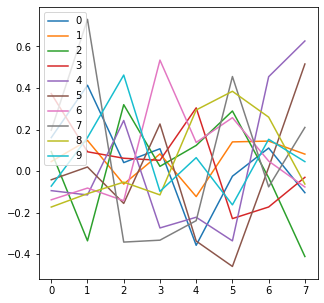

In [19]:
fig, ax = plt.subplots(figsize = (5.0, 5.0))
for i in range(10):
    ax.plot(z[i, 0:mm.y_dim].detach().to('cpu').numpy(), label = "%s" % i)
plt.legend()
plt.show()

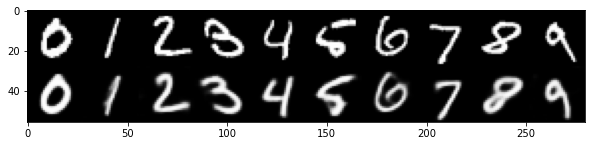

In [20]:
sample_data = []

sample_data.append(np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1))
sample_data.append(np.concatenate([recon[i,:,:] for i in range(10)], axis = 1))
sample_data = np.concatenate(sample_data, axis = 0)
fig = plt.figure(figsize=(10.0,10.0))
plt.imshow(sample_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.show()

# Sample Generation

## 1. Exemplar Generation

In [21]:
from XAE.sampler import gaus

exn = 5

In [22]:
zz = torch.cat((torch.zeros(1,mm.z_dim), gaus(exn,mm.z_dim)), dim = 0).to(device)
new_z = torch.cat((z[:,0:mm.y_dim].repeat_interleave(exn + 1, dim = 0).to(device), zz.repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

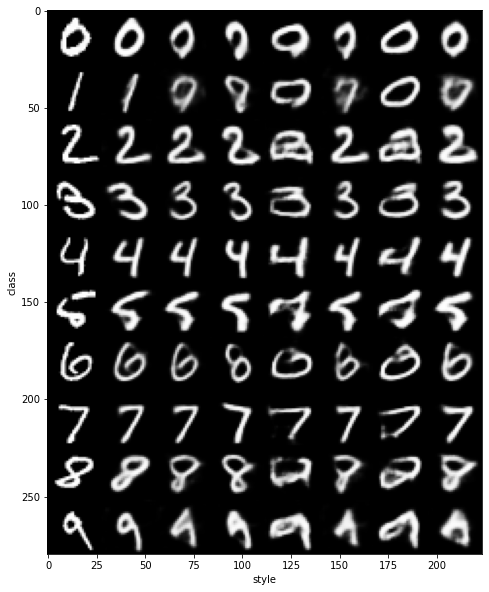

In [23]:
img_data = []
for i in range(10):
    img_data.append(np.concatenate([test_data[target[i]][0].numpy()[0,:,:]] + [recon[i,:,:]] + [new_x[(exn+1)*i + j] for j in range(exn+1)], axis = 1))
img_data = np.concatenate(img_data, axis = 0)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()

## 2. Style Transfer

In [24]:
new_z = torch.cat((z[:,:mm.y_dim].repeat_interleave(10, dim = 0), z[:,mm.y_dim:].repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

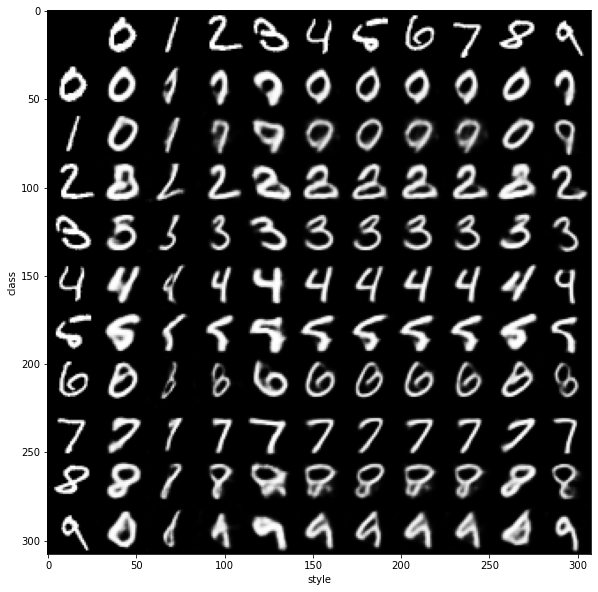

In [25]:
img_data = np.ones((28*11, 28*11))*-1
img_data[:28,28:] = np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1)
for i in range(10):
    img_data[((i+1)*28):((i+2)*28),:28] = test_data[target[i]][0].numpy()[0,:,:]
    img_data[((i+1)*28):((i+2)*28),28:] = np.concatenate(new_x[(10*i):(10*(i+1)),:,:], axis = 1)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()